In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim

from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [4]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

In [5]:
from fastcore.basics import get_annotations_ex
#get_annotations_ex??

Looking at the source code of "get_annotation_ex", this function is trying to return a tuple of dict(annotations), gloabls and locals associated with the function

#### Understanding Annotations in Python
Annotations are a way to attach type (or other) information to function parameters and return values.

In [6]:
def greet(name: str, age: int) -> str:
    return f"Hello {name}, I'm {age} years old."

greet('Hemant', 33)

"Hello Hemant, I'm 33 years old."

Here:

name: str and age: int are parameter annotations

-> str is the return annotation

We can access these like this:

In [7]:
print(greet.__annotations__)

{'name': <class 'str'>, 'age': <class 'int'>, 'return': <class 'str'>}


#### Understanding Globals in Python

Every function in Python remembers the global namespace (i.e., module-level variables and imports) in which it was defined.

In [8]:
PI = 3.14  # global

def area(radius: float) -> float:
    return PI * radius * radius

In [9]:
area.__globals__['PI'] # area_globals__ returns a dict, with all the global variables and their values in the notebook

3.14

#### Understanding Locals in Python

Local variables are defined within a function or block.

We can get local variables using locals() inside a function, or from the current frame outside.

In [10]:
def show_locals(x):
    y = x + 1
    print(locals())

show_locals(10)  # x and y are local variable to the funtion

{'x': 10, 'y': 11}


In [11]:
show_locals.__globals__['PI'] # but this function still has a global variable

3.14

#### Understanding how @fc.patch adds lr_find as a method to the learner class
Here's the source code for @fc_patch and lr_find, the get_annotation_ex gets passed the lr_find function through the decorator, let's see what it returns

In [12]:
#@fc.patch??

In [13]:
# @fc.patch
# def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
#     self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

In [14]:
# ann, glb, loc = get_annotations_ex(lr_find) # annotation contains that it's a miniai learner object
# ann #{'self': miniai.learner.Learner}

In [15]:
#from fastcore.basics import union2tuple, eval_type, patch_to

In [16]:
# cls = eval_type(ann.pop('cls') if False else next(iter(ann.values())), glb, loc)
# cls #miniai.learner.Learner

In [17]:
#pt = patch_to(cls, as_prop=False, cls_method=False, set_prop=False)(lr_find)

In [18]:
#patch_to??

#### Understanding the patch_to function:
Okay, a lot of Python going on here, buckle up

##### def patch_to(cls, as_prop=False, cls_method=False, set_prop=False):  

Returns a decorator that, when applied to a function, attaches that function to the given class (or classes).

Think of it as:

##### @patch_to(Learner)   
##### def new_method(self): ...

Becomes:

##### Learner.new_method = new_method   
But with extra features like handling @classmethod, @property, etc.

#### Define inner decorator

##### def _inner(f): ...
This is the actual decorator that modifies the class.

#### copy_func

##### nf = copy_func(f)
Makes a copy of the function f. This avoids side effects like double-decorating or overwriting the original.

#### Update wrapper metadata
##### for o in functools.WRAPPER_ASSIGNMENTS: setattr(nf, o, getattr(f, o))
This copies metadata like __name__, __doc__, etc., so tools like help() still work on the new method.

#### Update qualified name (nice for debugging)

##### nf.__qualname__ = f"{c_.__name__}.{nm}"

For example, Learner.lr_find

#### Attach function to class

##### if cls_method:
#####    setattr(c_, nm, _clsmethod(nf))
##### elif set_prop:
#####    setattr(c_, nm, getattr(c_, nm).setter(nf))
##### elif as_prop:
#####    setattr(c_, nm, property(nf))

This handles:

@classmethod

.setter for a property

@property

#### Default: attach normally, preserve original

##### else:
#####    onm = '_orig_' + nm
#####    if hasattr(c_, nm) and not hasattr(c_, onm):
#####        setattr(c_, onm, getattr(c_, nm))  # backup original
#####    setattr(c_, nm, nf)

So if Learner already had a method named nm (say lr_find), it will:

Save it as Learner._orig_lr_find

Overwrite Learner.lr_find with the new method

#### Return something safe

##### return globals().get(nm, builtins.__dict__.get(nm, None))
This avoids polluting the module's namespace. It doesn't return nf directly, because this decorator is mostly used for its side effect (patching the class), not its return value.

In [19]:
# So now we can do this, even though there wasn't a foo method in our Learner class

# @patch_to(Learner, cls_method=True)
# def foo(cls: Learner):  # Note: use `cls` not `self`
#     return f"Hi from {cls.__name__}"

# Learner.foo() #'Hi from Learner'

In [20]:
# @patch_to(Learner)
# def foo(self):
#     print('Hi')

#Learner.foo() #TypeError: foo() missing 1 required positional argument: 'self'

### Understanding instance method, class method and static method

In [21]:
# Instance method

class MyClass:
    def hello(self):
        return f"Hi from instance: {self}"

obj = MyClass()
print(obj.hello())
#print(MyClass.hello())  # TypeError: missing 1 required positional argument: 'self'

Hi from instance: <__main__.MyClass object at 0x7f4f997a9e50>


In [22]:
# Class Method

class MyClass:
    @classmethod
    def hello(cls):
        return f"Hi from class: {cls}"

print(MyClass.hello()) # no instance is needed — Python passes the class (cls) for us.

Hi from class: <class '__main__.MyClass'>


In [23]:
# Static method

class MyClass:
    @staticmethod
    def hello():
        return 'Hi'
            
print(MyClass.hello()) #Static methods are just functions attached to the class — no self or cls is passed.
obj = MyClass()
obj.hello() #if we comment out @static method and try to run this code
            #obj.hello() treats hello as an instance method, 
            #so Python automatically passes self — but your function doesn’t accept any arguments, so it crashes with
            #TypeError: hello() takes 0 positional arguments but 1 was given

Hi


'Hi'

### Understanding wrapper assignments

In [24]:
import functools
for o in functools.WRAPPER_ASSIGNMENTS:
    print(o)

__module__
__name__
__qualname__
__doc__
__annotations__


In [25]:
def greet(name: str) -> str:
    """Say hello to someone"""
    return f"Hello, {name}"

In [26]:
class Person:
    def say_hi(self, name):
        return f"Hello {name}"

In [27]:
## Output: '__main__' if in a script or notebook
# If this was defined in a file called utils.py, it would be 'utils'.
print(greet.__module__)

__main__


In [28]:
print(greet.__name__) #name of the function

greet


In [29]:
print(greet.__qualname__) #name of the function

greet


In [30]:
print(greet.__doc__) #qualname of the function

Say hello to someone


In [31]:
print(greet.__annotations__) #annotations

{'name': <class 'str'>, 'return': <class 'str'>}


In [32]:
print(Person.say_hi.__name__) #name of the function

say_hi


In [33]:
print(Person.say_hi.__qualname__) #name of the function (inside a class that's why Person.say_hi)

Person.say_hi


### Back to Initialization

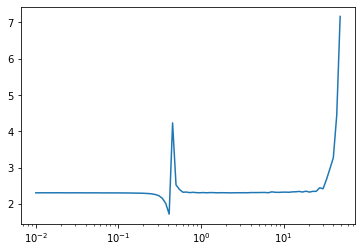

In [34]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [35]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.253,2.035,0,train
0.499,1.319,0,eval


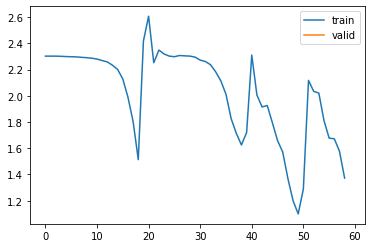

In [36]:
learn.fit(1)

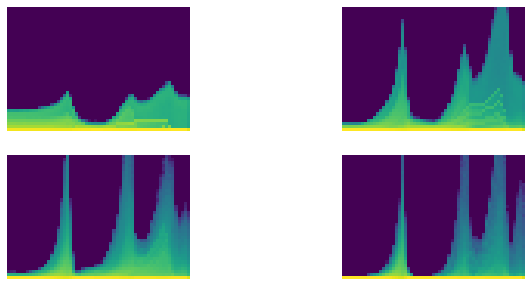

In [37]:
astats.color_dim()

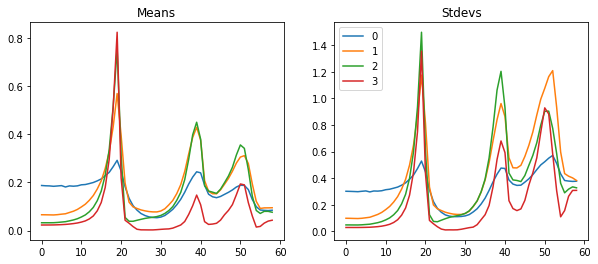

In [38]:
astats.plot_stats()

In [39]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [40]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [41]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

### Glorot/Xavier init

In [42]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100)
x[:5,:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [43]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.01)
x[:5,:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [44]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.1)
x[:5,:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

In [45]:
t = torch.tensor([1.,2.,4.,18])

In [46]:
m = t.mean()
m

tensor(6.25)

In [47]:
(t-m).mean()

tensor(0.)

In [48]:
(t-m).pow(2).mean()

tensor(47.19)

In [49]:
(t-m).abs().mean()

tensor(5.88)

In [50]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [51]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

### Covariance

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

In [52]:
t

tensor([ 1.,  2.,  4., 18.])

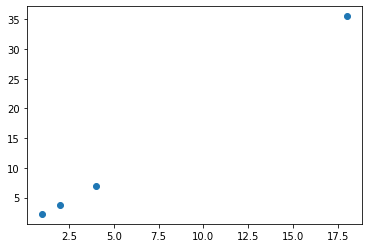

In [53]:
u = t * 2
u *= torch.randn_like(t)/10 + 0.95

plt.scatter(t, u);

In [54]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.67,  35.81,  11.57, 275.08])

In [55]:
prod.mean()

tensor(93.53)

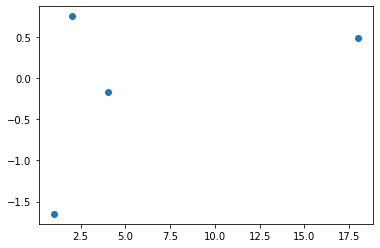

In [56]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [57]:
((t-t.mean())*(v-v.mean())).mean()

tensor(2.91)

In [58]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(2.91)

In [59]:
cov / (t.std() * v.std())

tensor(0.34)

In [60]:
prod.mean() / (t.std() * u.std())

tensor(0.75)

In [61]:
x.std()

tensor(1.13)

### Kaiming/He init

In [62]:
x = torch.randn(200,100)
y = torch.randn(100)
x.mean(), x.std(), y.mean(), y.std()

(tensor(0.00), tensor(1.00), tensor(-0.00), tensor(0.98))

In [63]:
from math import sqrt

In [64]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [65]:
w1.mean(), w1.std(), w2.mean(), w2.std()

(tensor(0.00), tensor(0.10), tensor(0.00), tensor(0.17))

In [66]:
def lin(x, w, b): return x @ w + b

In [67]:
l1 = lin(x, w1, b1)

In [68]:
l1.mean(), l1.std()

(tensor(0.01), tensor(1.00))

In [69]:
def relu(x): return x.clamp_min(0.)

In [70]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[:5, :5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [71]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[:5, :5]

tensor([[0.00, 0.72, 0.00, 1.06, 0.00],
        [0.00, 0.56, 0.00, 0.74, 0.00],
        [0.00, 0.66, 0.00, 0.87, 0.00],
        [0.00, 0.38, 0.00, 0.65, 0.00],
        [0.00, 0.45, 0.00, 0.62, 0.00]])

In [72]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [73]:
for m in model.children():
    print(type(m).__name__)

Sequential
Sequential
Sequential
Sequential
Conv2d
Flatten


In [74]:
for m in model.modules():
    print(type(m).__name__)

Sequential
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Conv2d
Flatten


In [75]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [76]:
model.apply(init_weights);

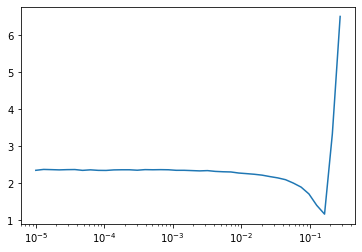

In [77]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [78]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=cbs)

accuracy,loss,epoch,train
0.634,1.071,0,train
0.799,0.547,0,eval
0.827,0.466,1,train
0.827,0.464,1,eval
0.852,0.400,2,train
0.850,0.414,2,eval


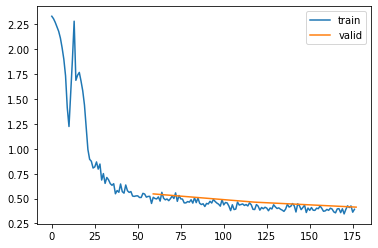

In [79]:
learn.fit(3)

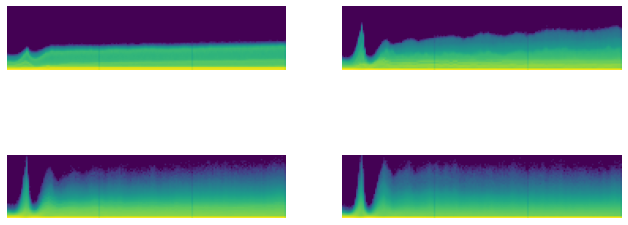

In [80]:
astats.color_dim()

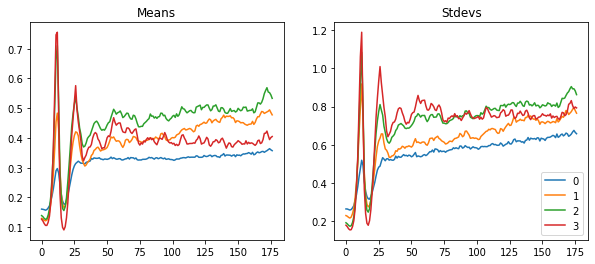

In [81]:
astats.plot_stats()

In [82]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

### Input Normalization

In [83]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_valid=True): fc.store_attr()
    
    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [84]:
def _norm(b): return (b[0]-xmean)/xstd, b[1]
norm = BatchTransformCB(_norm)

In [85]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=cbs+[norm])

accuracy,loss,epoch,train
0.657,1.040,0,train
0.809,0.524,0,eval
0.837,0.442,1,train
0.839,0.432,1,eval
0.859,0.384,2,train
0.854,0.395,2,eval


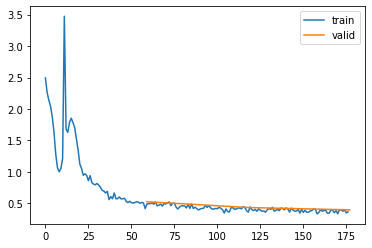

In [86]:
learn.fit(3)

We were using 1st batch's mean and std to normalize our batches, but we can compute mean and std for each batch dynamically and use them for normalizing.

In [87]:
def _norm(b):
    x, y = b
    mean = x.mean(dim=(0,), keepdim=True)
    std = x.std(dim=(0,), keepdim=True) + 1e-6
    return (x - mean) / std, y

In [88]:
norm = BatchTransformCB(_norm)

In [89]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=cbs+[norm])

accuracy,loss,epoch,train
0.710,0.841,0,train
0.817,0.503,0,eval
0.843,0.428,1,train
0.842,0.440,1,eval
0.864,0.375,2,train
0.863,0.388,2,eval
0.876,0.341,3,train
0.864,0.374,3,eval
0.883,0.321,4,train
0.871,0.358,4,eval


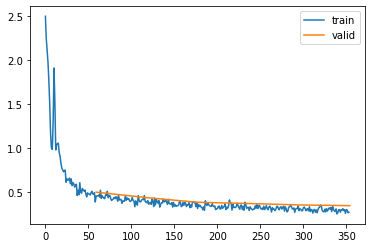

In [90]:
learn.fit(3)

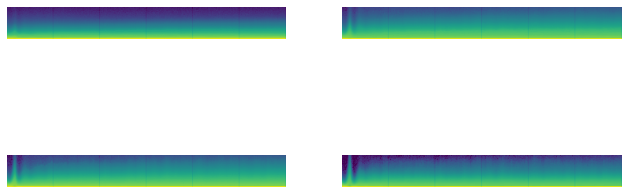

In [91]:
astats.color_dim()

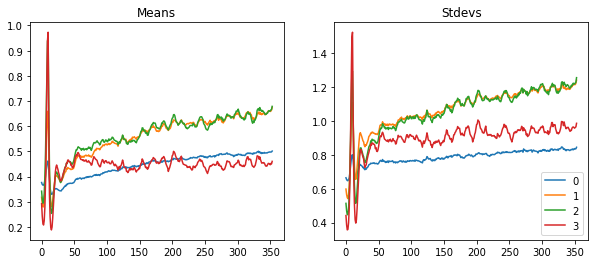

In [92]:
astats.plot_stats()

#### Why not normalize across channels?

This keeps relative color/feature intensity consistent. For example, if Red channels usually have higher values, you don’t want to flatten them down with a global average across all channels.

In [93]:
@inplace
def transformi(b):
    b[xl] = [
        (TF.to_tensor(o) - TF.to_tensor(o).mean(dim=(1, 2), keepdim=True)) /
        (TF.to_tensor(o).std(dim=(1, 2), keepdim=True) + 1e-6)
        for o in b[xl]
    ] 
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [94]:
xb.mean(), xb.std()

(tensor(    -0.00), tensor(1.00))

### General ReLU

In [95]:
class GeneralReLU(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None, maxv_slope=0.1):
        super().__init__()
        fc.store_attr()
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None:
            over = x > self.maxv
            over_x = x - self.maxv
            x = torch.where(over, self.maxv + over_x * self.maxv_slope, x)
        return x

In [96]:
def plot_func(f, start=-5, end=10, steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

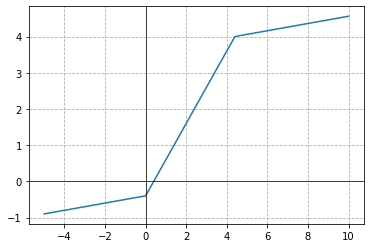

In [97]:
plot_func(GeneralReLU(leak=0.1,sub=0.4,maxv=4))

In [98]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [99]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1]) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [100]:
def init_weights(m, leaky=0.1):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

#### functools.partial

It works with any callable, not just function

In [101]:
class MyClass:
    def __init__(self, x, y):
        print(f"x={x}, y={y}")
        
myPartial = partial(MyClass, x=1)
myPartial(y=2)

x=1, y=2


Python automatically calls two things behind the scenes:

MyClass.__new__() – allocates memory and returns a new instance.

MyClass.__init__() – initializes the instance (this is where your constructor logic happens).

So even if you don’t define a __call__ method, the class itself is still callable — because the metaclass (type by default) defines a __call__ method that wraps __new__ and __init__. 

In [107]:
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [108]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.315,2.084,0,train
0.492,1.323,0,eval
0.710,0.798,1,train
0.797,0.555,1,eval
0.815,0.500,2,train
0.823,0.471,2,eval


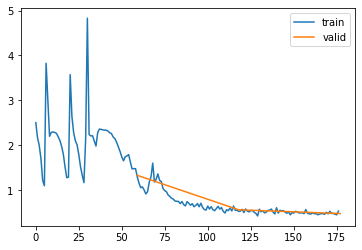

In [109]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [110]:
astats.color_dim()

ZeroDivisionError: division by zero

In [113]:
get_grid??

Signature:
get_grid(
    n: 'int',
    nrows: 'int' = None,
    ncols: 'int' = None,
    title: 'str' = None,
    weight: 'str' = 'bold',
    size: 'int' = 14,
    *,
    figsize: 'tuple' = None,
    imsize: 'int' = 3,
    suptitle: 'str' = None,
    sharex=False,
    sharey=False,
    squeeze=True,
    subplot_kw=None,
    gridspec_kw=None,
)
Source:   
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrow

In [111]:
ActivationStats??

Init signature: ActivationStats(mod_filter=<function noop at 0x7f4fab841310>)
Docstring:      <no docstring>
Source:        
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))
File:           /notebooks/course22p2/miniai/activations.py
Type:       

In [112]:
HooksCallback??

Init signature:
HooksCallback(
    hookfunc,
    mod_filter=<function noop at 0x7f4fab841310>,
    on_train=True,
    on_valid=False,
    mods=None,
)
Docstring:      <no docstring>
Source:        
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)
File:           /notebooks/course22p2/miniai/activations.py
Type:           type
Subclasses: 

In [ ]:
astats.plot_stats()

In [ ]:
astats.dead_chart()

### Layer-wise Sequential Unit-Variance (LSUV)

In [ ]:
def _lsuv_stat(hook, mod, inp, out):
    act = to_cpu(out)
    hook.mean = act.mean()
    hook.std = act.std()

In [ ]:
def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stat)
    with torch.no_grad():
        while model(xb) is not None and abs((h.std-1.)) > 1e-3 or abs(h.mean) > 1e-3:
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [ ]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralReLU)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [ ]:
for ms in zip(relus, convs): print(ms)

In [ ]:
for ms in zip(relus, convs): lsuv_init(model, *ms, xb.to(def_device))

In [ ]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [ ]:
astats.color_dim()

In [ ]:
astats.plot_stats()

### Layer Norm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        x = (x - m) / ((v + self.eps).sqrt())
        return x * self.mult + self.add

In [ ]:
def conv(ni, nf, stride=2, ks=3, act=nn.ReLU, bias=None, norm=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [ ]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=False, bias=True), nn.Flatten()).to(def_device)

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [ ]:
astats.color_dim()